**Nota:**

*   Se debe tener encuenta que el google colab debe estar conectado en T4
*   Se descarga la carpeta compartida (Dataset2)
*   Se crea en el propio drive de la persona una carpeta con el mismo nombre (Dataset2)
*   Se pega todo el contenido de la carpeta descargada



# **1. Se importa el Dataset**



*   Se debe iniciar el entorno ejecución del dataset
*   Para montar la unidad de Google Drive en el directorio /content/drive dentro del entorno de trabajo y acceder al dataset compartido en la carpeta "Dataset2".
1.   from google.colab import drive: Esta línea importa la funcionalidad necesaria para interactuar con Google Colab, que es el entorno de trabajo que estamos utilizando.
2.   drive.mount('/content/drive'): Esta línea monta la unidad de Google Drive en el directorio /content/drive dentro de nuestro entorno de trabajo. Ahora podemos acceder a los archivos almacenados en Google Drive como si estuvieramos en nuestro propio computador.



E

In [ ]:
#Primer paso para correr la red neuronal
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. Instalación de tensorflow**


En esta linea instalamos la biblioteca de TensorFlow en el entorno de trabajo que estamos utilizando, el sistema va a descargar e instalar la última versión de TensorFlow, junto con todas las dependencias necesarias. Esto nos permitirá utilizar las funcionalidades y herramientas para nuestro código de red neuronal.
Una vez  instalado, podremos importar y utilizar sus módulos y funciones en nuestro código, permitiendo definir la arquitectura de nuestra red neuronal, entrenarla y evaluarla.

E

In [ ]:
!pip install tensorflow==2.15.1

# **2. Se importan las Librerias**


*   Se importan una serie de bibliotecas y módulos que serán necesarios. Estas bibliotecas proporcionan funcionalidades para trabajar con archivos, procesar datos, realizar cálculos matemáticos y  crear visualizaciones.
*   Es necesario la ejecución de las librerias para el correcto funcionamiento del proceso.

E

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
from datetime import datetime
import cv2
import datetime
import numpy as np
import re
import pandas as pd
import seaborn as sns
from tensorflow.keras.callbacks import CSVLogger
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True #Para procesar imagenes truncadas

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **3. Generar rutas de archivos con etiquetas**

El código define funciones para organizar y preparar archivos e imágenes para entrenar modelos de aprendizaje automático. Primero, define_paths genera listas de rutas de archivos y sus etiquetas correspondientes en base a la estructura de carpetas. Luego, define_df concatena estas listas en un único dataframe. Finalmente, split_data divide este dataframe en conjuntos de entrenamiento, validación y prueba, asegurando que los datos estén equilibrados y listos para su uso en el entrenamiento de modelos.


E

In [ ]:
# Generar rutas de archivos con etiquetas
def define_paths(data_dir):
    filepaths = []  # Lista para almacenar las rutas de archivos
    labels = []  # Lista para almacenar las etiquetas de las imágenes

    folds = os.listdir(data_dir)  # Obtener una lista de todas las carpetas en el directorio de datos
    for fold in folds:  # Iterar sobre cada carpeta
        foldpath = os.path.join(data_dir, fold)  # Construir la ruta completa de la carpeta
        filelist = os.listdir(foldpath)  # Obtener una lista de todos los archivos en la carpeta
        for file in filelist:  # Iterar sobre cada archivo
            fpath = os.path.join(foldpath, file)  # Construir la ruta completa del archivo
            filepaths.append(fpath)  # Agregar la ruta del archivo a la lista
            labels.append(fold)  # Agregar la etiqueta de la carpeta a la lista

    return filepaths, labels  # Devolver las listas de rutas de archivos y etiquetas


# Concatenar rutas de archivos con etiquetas en un solo dataframe
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')  # Crear una serie de Pandas con las rutas de archivos
    Lseries = pd.Series(classes, name='labels')  # Crear una serie de Pandas con las etiquetas
    return pd.concat([Fseries, Lseries], axis= 1)  # Concatenar las series en un solo dataframe


# Dividir el dataframe en conjuntos de entrenamiento, validación y prueba
def split_data(data_dir):
    # Conjunto de entrenamiento
    files, classes = define_paths(data_dir)  # Obtener las rutas de archivos y etiquetas
    df = define_df(files, classes)  # Crear un dataframe a partir de las rutas y etiquetas
    strat = df['labels']  # Obtener las etiquetas del dataframe
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)  # Dividir el dataframe en conjuntos de entrenamiento y prueba

    # Conjuntos de validación y prueba
    strat = dummy_df['labels']  # Obtener las etiquetas del dataframe
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)  # Dividir el dataframe en conjuntos de validación y prueba

    return train_df, valid_df, test_df  # Devolver los conjuntos de entrenamiento, validación y prueba

# **Creación de Generadores de Datos de Imágenes**

El código define una función create_gens que adapta los dataframes de entrenamiento, validación y prueba para ser utilizados por un generador de datos de imágenes. Este generador convierte las imágenes en tensores que pueden ser utilizados por el modelo de aprendizaje automático. La función establece el tamaño de las imágenes, el número de canales, y los parámetros de aumento de datos. Luego, crea generadores específicos para los conjuntos de entrenamiento, validación y prueba, configurando el tamaño de los lotes y el modo de color.

E

In [ ]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    Esta función toma los dataframes de entrenamiento, validación y prueba, y los adapta a un generador de datos de imágenes, ya que el modelo toma los datos de un generador de datos de imágenes.
    El generador de datos de imágenes convierte las imágenes en tensores.
    '''

    # Definir parámetros del modelo
    img_size = (224, 224)
    channels = 3 # o BGR o escala de grises
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recomendado: utilizar una función personalizada para el tamaño del lote de prueba, de lo contrario podemos utilizar un tamaño de lote normal.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # Esta función se utilizará en el generador de datos de imágenes para la augmentación de datos, simplemente toma la imagen y la devuelve.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Nota: utilizaremos un tamaño de lote de prueba personalizado y haremos shuffle= False
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

# **Visualización de Imágenes con el Generador de Datos**
La función show_images toma un generador de datos de imágenes y muestra una muestra de estas imágenes con sus respectivas etiquetas. Primero, obtiene las clases y las imágenes del generador. Luego, define cuántas imágenes se mostrarán, asegurándose de que el máximo sea 25. Finalmente, muestra cada imagen en una cuadrícula de 5x5, escalando los valores de píxeles y mostrando la clase de cada imagen como título.

E

In [ ]:
def show_images(gen):
    '''
    Esta función toma el generador de datos y muestra una muestra de las imágenes.
    '''

    # Devuelve las clases y las imágenes a mostrar
    g_dict = gen.class_indices        # Define un diccionario {'clase': índice}
    classes = list(g_dict.keys())     # Define una lista de las claves del diccionario (clases), nombres de clase: cadena
    images, labels = next(gen)        # Obtiene una muestra de tamaño batch del generador

    # Calcula el número de muestras a mostrar
    length = len(labels)        # Longitud de la muestra
    sample = min(length, 25)    # Verifica si la muestra es menor que 25 imágenes

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # Escala los datos al rango (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # Obtiene el índice de la imagen
        class_name = classes[index]   # Obtiene la clase de la imagen
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

# **Callback Personalizado para Ajuste de la Tasa de Aprendizaje**

La clase MyCallback extiende la funcionalidad de keras.callbacks.Callback para ajustar automáticamente la tasa de aprendizaje durante el entrenamiento de un modelo de aprendizaje profundo. Este callback se encarga de reducir la tasa de aprendizaje cuando la precisión de entrenamiento o la pérdida de validación no mejoran después de un cierto número de épocas, basado en un umbral predefinido. Si el modelo no muestra mejora tras varios ajustes de la tasa de aprendizaje, el entrenamiento se detiene automáticamente. La clase también registra y muestra información detallada de cada época y el tiempo total de entrenamiento.

E

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch=None):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience  # especifica cuántos epochs sin mejora antes de ajustar la tasa de aprendizaje
        self.stop_patience = stop_patience  # especifica cuántas veces se ajustará la tasa de aprendizaje sin mejora para detener el entrenamiento
        self.threshold = threshold  # especifica el umbral de precisión de entrenamiento cuando la tasa de aprendizaje se ajustará basada en la pérdida de validación
        self.factor = factor  # factor por el que se reducirá la tasa de aprendizaje
        self.batches = batches  # número de lotes de entrenamiento que se ejecutarán por epoch
        self.epochs = epochs #numero de epochs o epocas por entrenamiento

        # variables de callback
        self.count = 0  # cuenta cuántas veces se ha reducido la tasa de aprendizaje sin mejora
        self.stop_count = 0
        self.best_epoch = 1  # epoch con la pérdida más baja
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # obtiene la tasa de aprendizaje inicial y la guarda
        self.highest_tracc = 0.0  # establece la precisión de entrenamiento más alta en 0 inicialmente
        self.lowest_vloss = np.inf  # establece la pérdida de validación más baja en infinito inicialmente
        self.best_weights = self.model.get_weights()  # establece las mejores pesas como las pesas iniciales del modelo
        self.initial_weights = self.model.get_weights()  # guarda las pesas iniciales si se deben restaurar

    def on_train_begin(self, logs=None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'el tiempo de entrenamiento transcurrido fue {str(hours)} horas, {minutes:4.1f} minutos, {seconds:4.2f} segundos)'
        print(msg)

        # establece las pesas del modelo en las mejores pesas
        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        # obtiene la precisión y la pérdida del lote de entrenamiento
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # imprime sobre la misma línea para mostrar el recuento de lotes de entrenamiento en ejecución
        msg = '{0:20s}procesando lote {1:} de {2:5s}-   precisión=  {3:5.3f}   -   pérdida: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))  # obtiene la tasa de aprendizaje actual
        current_lr = lr
        acc = logs.get('accuracy')  # obtiene la precisión de entrenamiento
        v_acc = logs.get('val_accuracy')  # obtiene la precisión de validación
        loss = logs.get('loss')  # obtiene la pérdida de entrenamiento para este epoch
        v_loss = logs.get('val_loss')  # obtiene la pérdida de validación para este epoch

        if acc < self.threshold:  # si la precisión de entrenamiento es menor que el umbral, ajuste la tasa de aprendizaje basada en la precisión de entrenamiento
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc  # define la mejora del progreso del modelo

            if acc > self.highest_tracc:  # la precisión de entrenamiento mejoró en el epoch
                self.highest_tracc = acc  # establece la nueva precisión de entrenamiento más alta
                self.best_weights = self.model.get_weights()  # la precisión de entrenamiento mejoró, así que guarde las pesas
                self.count = 0  # restablece el contador a 0 ya que la precisión de entrenamiento mejoró
                self.stop_count = 0  # restablece el contador de paradas a 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # establece el valor del mejor epoch para este epoch

            else:
                # la precisión de entrenamiento no mejoró, verifique si esto ha sucedido durante el número de epochs de paciencia
                # si es así, ajuste la tasa de aprendizaje
                if self.count >= self.patience - 1:  # se debe ajustar la tasa de aprendizaje
                    lr = lr * self.factor  # ajuste la tasa de aprendizaje por factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)  # establezca la tasa de aprendizaje en el optimizador
                    self.count = 0  # restablece el contador a 0
                    self.stop_count = self.stop_count + 1  # cuenta el número de ajustes de tasa de aprendizaje consecutivos
                    self.count = 0  # restablece el contador a 0 otra vez
                    if v_loss < self.lowest_vloss:  # Se verifica si la pérdida de validación actual es menor que la pérdida de validación más baja registrada hasta ahora
                        self.lowest_vloss = v_loss  # Si es así, se actualiza el valor de la pérdida de validación más baja con el valor de la pérdida de validación actual
                else:
                    self.count = self.count + 1  # Se incrementa el contador de paciencia.

        else:  # Si la precisión de entrenamiento está por encima del umbral, se ajusta la tasa de aprendizaje en función de la pérdida de validación.
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss:  # Se verifica si la pérdida de validación ha mejorado
                self.lowest_vloss = v_loss  #Se reemplaza la pérdida de validación más baja con la nueva pérdida de validación
                self.best_weights = self.model.get_weights()  # Se ajusta la tasa de aprendizaje
                self.count = 0  # restablecer el recuento desde que se mejoró loss validation
                self.stop_count = 0
                self.best_epoch = epoch + 1  # establecer el valor del mejor epoch para este epoch

            else:  # Si la pérdida de validación no ha mejorado
                if self.count >= self.patience - 1:  # Se necesita ajustar la tasa de aprendizaje
                    lr = lr * self.factor  # ajustar la tasa de aprendizaje
                    self.stop_count = self.stop_count + 1  # incrementar el contador de parada porque se ajustó lr
                    self.count = 0  # resetea el contador
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)  # establece la tasa de aprendizaje en el optimizador
                else:
                    self.count = self.count + 1  # Se incrementa el contador de paciencia

            if acc > self.highest_tracc:
                self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:  # Se verifica si se ha ajustado la tasa de aprendizaje stop_count veces sin mejora
            msg = f'El entrenamiento se ha detenido en el epoch {epoch + 1} después de {self.stop_patience} ajustes de la tasa de aprendizaje sin ninguna mejora.'
            print(msg)
            self.model.stop_training = True  # Se detiene el entrenamiento

# **Graficar el Historial de Entrenamiento**

La función plot_training toma todos los archivos CSV de una carpeta, traza el historial de precisión y pérdidas durante el entrenamiento, y guarda las imágenes generadas en la misma carpeta. Primero, lee cada archivo CSV y extrae los datos de precisión y pérdida para el entrenamiento y la validación. Luego, crea gráficos que muestran estos valores a lo largo de las épocas, destacando los puntos con la mejor precisión y la menor pérdida de validación. Finalmente, guarda los gráficos generados como archivos de imagen en la misma carpeta donde se encuentran los CSV.

In [ ]:
def plot_training(csv_folder):
    '''
    Esta función toma todos los archivos CSV de una carpeta, traza el historial de precisión y pérdidas,
    y guarda las imágenes generadas en la misma carpeta.
    '''
    # Obtener todos los archivos .csv de la carpeta
    csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]

    for csv_file in csv_files:
        # Leer el CSV
        df = pd.read_csv(os.path.join(csv_folder, csv_file))

        # Definir variables necesarias
        tr_acc = df['accuracy'] # Accuracy de entrenamiento
        tr_loss = df['loss'] # Pérdida de entrenamiento
        val_acc = df['val_accuracy'] # Accuracy de validación
        val_loss = df['val_loss'] # Pérdida de validación
        index_loss = np.argmin(val_loss) # Índice de la pérdida de validación más baja
        val_lowest = val_loss[index_loss] # Valor de la pérdida de validación más baja
        index_acc = np.argmax(val_acc) # Índice de la precisión de validación más alta
        acc_highest = val_acc[index_acc] # Valor de la precisión de validación más alta
        Epochs = [i+1 for i in range(len(tr_acc))] # Epochs
        loss_label = f'best epoch= {str(index_loss + 1)}' # Etiqueta para el mejor epoch de pérdida
        acc_label = f'best epoch= {str(index_acc + 1)}' # Etiqueta para el mejor epoch de precisión

        # Graficar historial de entrenamiento
        plt.figure(figsize= (20, 8)) # Tamaño de la figura
        plt.style.use('fivethirtyeight') # Estilo de la gráfica

        plt.subplot(1, 2, 1) # Subgráfico para pérdidas
        plt.plot(Epochs, tr_loss, 'r', label= 'Training loss') # Pérdida de entrenamiento
        plt.plot(Epochs, val_loss, 'g', label= 'Validation loss') # Pérdida de validación
        plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label) # Punto de el mejor epoch de pérdida
        plt.title('Training and Validation Loss') # Título del gráfico de pérdidas
        plt.xlabel('Epochs') # Etiqueta del eje x
        plt.ylabel('Loss') # Etiqueta del eje y
        plt.legend() # Leyenda

        plt.subplot(1, 2, 2) # Subgráfico para precisión
        plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy') # Precisión de entrenamiento
        plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy') # Precisión de validación
        plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label) # Punto de el mejor epoch de precisión
        plt.title('Training and Validation Accuracy') # Título del gráfico de precisión
        plt.xlabel('Epochs') # Etiqueta del eje x
        plt.ylabel('Accuracy') # Etiqueta del eje y
        plt.legend() # Leyenda

        plt.tight_layout() # Ajustar diseño

        # Guardar la imagen en la misma carpeta
        image_file = os.path.join(csv_folder, f"{os.path.splitext(csv_file)[0]}_plot.png")
        plt.savefig(image_file)
        plt.close()

# Ejemplo de uso:
# plot_training('/content/drive/MyDrive/Reportes dataset2 v1/vgg19/0.0001')
        plt.tight_layout # Ajustar diseño
        plt.show() # Mostrar gráficos

In [ ]:
def calcular_varianza_general(ruta_base):
    resultados = []

    for carpeta_lr in os.listdir(ruta_base):
        ruta_lr = os.path.join(ruta_base, carpeta_lr)

        if os.path.isdir(ruta_lr):
            # Ruta del archivo resumen_resultados.csv
            archivo_resumen = os.path.join(ruta_lr, 'resumen_resultados.csv')

            if os.path.exists(archivo_resumen):
                # Leer el archivo CSV
                df = pd.read_csv(archivo_resumen)

                # Extraer las columnas necesarias: max_val_accuracy y min_val_loss
                val_accuracies = df['max_val_accuracy'].tolist()
                val_losses = df['min_val_loss'].tolist()

                # Calcular la varianza de val_loss y val_accuracy para este learning rate
                if val_losses and val_accuracies:
                    varianza_val_loss = np.var(val_losses)
                    varianza_val_accuracy = np.var(val_accuracies)

                    # Almacenar los resultados de la varianza
                    resultados.append({
                        'learning_rate': float(carpeta_lr),
                        'varianza_val_loss': varianza_val_loss,
                        'varianza_val_accuracy': varianza_val_accuracy
                    })

    # Convertir los resultados a un DataFrame
    results_df = pd.DataFrame(resultados)

    # Guardar los resultados en un archivo CSV
    results_df.to_csv(f'{ruta_base}/varianza_general.csv', index=False)

    print(f"Varianzas guardadas en {ruta_base}/varianza_general.csv")

In [ ]:
# Especificar la carpeta base donde están las carpetas de los learning rates
ruta_base = "/content/drive/MyDrive/Reportes dataset2 v1/vgg19"
calcular_varianza_general(ruta_base)

Varianzas guardadas en /content/drive/MyDrive/Reportes dataset2 v1/vgg19/varianza_general.csv


# **Graficar Resultados del Entrenamiento de Modelos**

La función plot_training procesa los archivos CSV en una carpeta, grafica el historial de precisión y pérdidas durante el entrenamiento, y guarda las imágenes generadas en la misma carpeta.

In [ ]:
plot_training("/content/drive/MyDrive/Reportes dataset2 v1/vgg19/0.01")

# **Graficar la Matriz de Confusión**
La función plot_confusion_matrix genera un gráfico de la matriz de confusión utilizando el método de sklearn. Esta función acepta como parámetros la matriz de confusión (cm), las clases correspondientes, una opción para normalizar los datos, un título para el gráfico y un mapa de colores (cmap). La función visualiza la matriz, muestra las etiquetas correspondientes en los ejes x e y, y opcionalmente normaliza los valores. También agrega los valores de cada celda en el gráfico para una interpretación más clara.

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusión', cmap=plt.cm.Blues):
    '''
    Esta función grafica la matriz de confusión utilizando el método de sklearn.
    '''

    plt.figure(figsize=(10, 10)) # Tamaño de la figura
    plt.imshow(cm, interpolation='nearest', cmap=cmap) # Imagen de la matriz de confusión
    plt.title(title) # Título del gráfico
    plt.colorbar() # Barra de color para indicar la correspondencia entre los valores y los colores

    tick_marks = np.arange(len(classes)) # Marcas de los ejes
    plt.xticks(tick_marks, classes, rotation=45) # Etiquetas para el eje x con rotación de 45 grados
    plt.yticks(tick_marks, classes) # Etiquetas para el eje y

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalización de la matriz de confusión
        print('Matriz de Confusión Normalizada') # Mensaje indicando que la matriz está normalizada

    else:
        print('Matriz de Confusión sin Normalizar') # Mensaje indicando que la matriz no está normalizada

    print(cm) # Imprimir la matriz de confusión

    thresh = cm.max() / 2. # Umbral para el texto en las celdas de la matriz
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black') # Añadir el valor de cada celda

    plt.tight_layout() # Ajustar el diseño de la figura
    plt.ylabel('Etiqueta Real') # Etiqueta del eje y
    plt.xlabel('Etiqueta Predicha') # Etiqueta del eje x

# **Análisis de Resultados de Experimentos de Aprendizaje Automático**
Este programa está diseñado para analizar y comparar los resultados de varios experimentos de aprendizaje automático almacenados en archivos de texto. Organiza las carpetas por tasas de aprendizaje y extrae las métricas de precisión y pérdida de validación de cada repetición. Luego, identifica la repetición con el mejor rendimiento para cada tasa de aprendizaje y guarda un resumen de estos resultados en un archivo CSV, proporcionando una visión clara y concisa de las mejores configuraciones experimentales.

In [ ]:
def encontrar_mejores_metricas(ruta_base):
    resultados = []

    for carpeta_lr in os.listdir(ruta_base):
        ruta_lr = os.path.join(ruta_base, carpeta_lr)

        if os.path.isdir(ruta_lr):
            mejor_val_acc = 0  # Inicializar mejor_val_acc
            mejor_val_loss = float('inf')  # Inicializar mejor_val_loss
            mejor_repeticion = None  # Inicializar mejor repeticion

            for archivo in os.listdir(ruta_lr):
                if archivo.endswith('.txt'):
                    ruta_archivo = os.path.join(ruta_lr, archivo)
                    repeticion = archivo.split('rep_')[-1].split('.txt')[0]

                    with open(ruta_archivo, 'r') as f:
                        lineas = f.readlines()

                    val_acc = 0
                    val_loss = float('inf')

                    for linea in lineas:
                        if 'Val Accuracy:' in linea:
                            val_acc = float(linea.split('Val Accuracy: ')[1].split()[0])
                        if 'Val Loss:' in linea:
                            val_loss = float(linea.split('Val Loss: ')[1].split()[0])

                    # Comparar y actualizar si encontramos una mejor repetición
                    if val_acc > mejor_val_acc or (val_acc == mejor_val_acc and val_loss < mejor_val_loss):
                        mejor_val_acc = val_acc
                        mejor_val_loss = val_loss
                        mejor_repeticion = int(repeticion)

            # Almacenar los resultados de la mejor repetición para este learning rate
            resultados.append({
                'learning_rate': float(carpeta_lr),
                'repeticion': mejor_repeticion,
                'mejor_val_accuracy': mejor_val_acc,
                'mejor_val_loss': mejor_val_loss
            })

    results_df = pd.DataFrame(resultados)
    # Guardar los resultados en un nuevo archivo CSV
    results_df.to_csv(f'{ruta_base}resumen_general.csv', index=False)

    print(f"Resumen guardado en {ruta_base}resumen_general.csv")

# **Encontrar las Mejores Métricas en Archivos CSV**
Este código está diseñado para ayudar a encontrar las mejores métricas de rendimiento de modelos almacenadas en archivos CSV dentro de un directorio específico. Primero, la función encontrar_mejores_metricas inicializa un diccionario vacío para almacenar las métricas óptimas. Luego, recorre todos los archivos en el directorio dado (base_path). Para cada archivo, verifica si es un archivo CSV y, en caso afirmativo, lo lee utilizando la biblioteca pandas. Finalmente, extrae y compara las métricas de cada archivo para determinar las mejores, almacenándolas en el diccionario previamente inicializado

In [ ]:
base_path = '/content/drive/MyDrive/Reportes dataset2 v1/vgg19/'
encontrar_mejores_metricas(base_path)

Resumen guardado en /content/drive/MyDrive/Reportes dataset2 v1/vgg19/resumen_general.csv


## **Análisis de Estadísticas de Archivos CSV en una Carpeta**

Este programa realiza un análisis detallado de múltiples archivos CSV almacenados en una carpeta específica. Extrae información crucial de cada archivo, como la precisión máxima de validación y la pérdida mínima de validación, junto con las épocas correspondientes en las que se alcanzaron estos valores. Además, organiza estos datos junto con el número de repetición (extraído del nombre del archivo) en un nuevo archivo CSV llamado resumen_resultados.csv. Este archivo resumen facilita la comparación y el análisis de los resultados obtenidos en diferentes ejecuciones, proporcionando una visión clara y organizada del rendimiento de los modelos analizados.


In [ ]:
def calcular_estadisticas(carpeta):
    # Listar todos los archivos en la carpeta
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.csv')]

    resultados = []

    # Expresión regular para extraer el número de repetición del nombre del archivo
    patron_repeticion = re.compile(r'rep_(\d+)')

    for archivo in archivos:
        ruta = os.path.join(carpeta, archivo)

        # Cargar el archivo CSV
        df = pd.read_csv(ruta)

        # Encontrar el val_accuracy más alto y su epoch
        max_val_acc = df['val_accuracy'].max()
        max_val_acc_epoch = df[df['val_accuracy'] == max_val_acc]['epoch'].values[0]

        # Encontrar el val_loss más bajo y su epoch
        min_val_loss = df['val_loss'].min()
        min_val_loss_epoch = df[df['val_loss'] == min_val_loss]['epoch'].values[0]

        # Extraer el número de repetición del nombre del archivo
        match = patron_repeticion.search(archivo)
        if match:
            repeticion = int(match.group(1))
        else:
            repeticion = None

        # Guardar los resultados en una lista
        resultados.append({
            'repeticion': repeticion,
            'max_val_accuracy': max_val_acc,
            'epoch_max_val_accuracy': max_val_acc_epoch,
            'min_val_loss': min_val_loss,
            'epoch_min_val_loss': min_val_loss_epoch
        })

    print(resultados)
    # Crear un DataFrame con los resultados
    results_df = pd.DataFrame(resultados)

    # Guardar los resultados en un nuevo archivo CSV
    results_df.to_csv(f'{carpeta}/resumen_resultados.csv', index=False)

    print(f"Resumen guardado en {carpeta}/resumen_resultados.csv")

# **Cálculo de estadísticas de entrenamiento**
Estas líneas de código ejecutan la función calcular_estadisticas() con la ruta '/content/drive/MyDrive/Reportes dataset2 v1/vgg19/{learning rate}' como argumento. Esta función se encarga de analizar los archivos de registro de entrenamiento (logs) almacenados en la carpeta especificada y calcular estadísticas relevantes.
Al ejecutar esta función, se procesarán todos los archivos de registro de entrenamiento (con extensión .csv) que se encuentren en la carpeta '/content/drive/MyDrive/Reportes dataset2 v1/vgg19/{learning rate}'. Para cada archivo, se extraerán métricas como la precisión y la pérdida de entrenamiento y validación, y se calcularán estadísticas como la mejor época (con menor pérdida de validación), la precisión y pérdida promedio, y la precisión y pérdida máximas.

In [ ]:
carpeta = '/content/drive/MyDrive/Reportes dataset2 v1/vgg19/0.0001'
calcular_estadisticas(carpeta)
carpeta = '/content/drive/MyDrive/Reportes dataset2 v1/vgg19/0.001'
calcular_estadisticas(carpeta)
carpeta = '/content/drive/MyDrive/Reportes dataset2 v1/vgg19/0.01'
calcular_estadisticas(carpeta)

[{'repeticion': 1, 'max_val_accuracy': 0.9493975639343262, 'epoch_max_val_accuracy': 28, 'min_val_loss': 1.2685962915420532, 'epoch_min_val_loss': 34}, {'repeticion': 2, 'max_val_accuracy': 0.9542168378829956, 'epoch_max_val_accuracy': 39, 'min_val_loss': 1.0596232414245603, 'epoch_min_val_loss': 38}, {'repeticion': 3, 'max_val_accuracy': 0.942168653011322, 'epoch_max_val_accuracy': 22, 'min_val_loss': 1.0745171308517456, 'epoch_min_val_loss': 38}, {'repeticion': 4, 'max_val_accuracy': 0.9493975639343262, 'epoch_max_val_accuracy': 33, 'min_val_loss': 1.0443648099899292, 'epoch_min_val_loss': 39}, {'repeticion': 5, 'max_val_accuracy': 0.9325301051139832, 'epoch_max_val_accuracy': 24, 'min_val_loss': 0.5527432560920715, 'epoch_min_val_loss': 29}, {'repeticion': 6, 'max_val_accuracy': 0.9590361714363098, 'epoch_max_val_accuracy': 23, 'min_val_loss': 0.9440901875495912, 'epoch_min_val_loss': 26}, {'repeticion': 7, 'max_val_accuracy': 0.9325301051139832, 'epoch_max_val_accuracy': 23, 'min_v

# **Preparación y Generación de Datos**
Este código prepara y genera datos para el entrenamiento, validación y prueba de un modelo de aprendizaje automático. Primero, define la variable data_dir con la ruta al directorio de datos, considerando opciones para el dueño de la carpeta y los usuarios compartidos. Luego, intenta dividir los datos en subconjuntos de entrenamiento, validación y prueba mediante la función split_data. Utilizando la función create_gens, crea generadores de datos para cada subconjunto con un tamaño de lote de 16. Si ocurre algún error durante este proceso, se captura la excepción y se imprime el mensaje 'Invalid Input', asegurando así un manejo robusto de errores.

E

In [ ]:
data_dir="/content/drive/MyDrive/dataset2" #Para el dueño de la carpeta, data_dir="/content/drive/Shareddrives/dataset2" es para los que se les compartieron la carpeta

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 16
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 3319 validated image filenames belonging to 2 classes.
Found 415 validated image filenames belonging to 2 classes.
Found 415 validated image filenames belonging to 2 classes.


# **Visualización de las imágenes de entrenamiento**



Cuando se ejecuta esta línea, la función show_images() toma una muestra de las imágenes y etiquetas del generador de entrenamiento y las muestra en una cuadrícula de 5x4. Visualizando una pequeña parte de los datos de entrenamiento y tener una idea de las características y diversidad de las imágenes que el modelo deberá aprender a procesar.


E, tienen que salir 16 imagenes

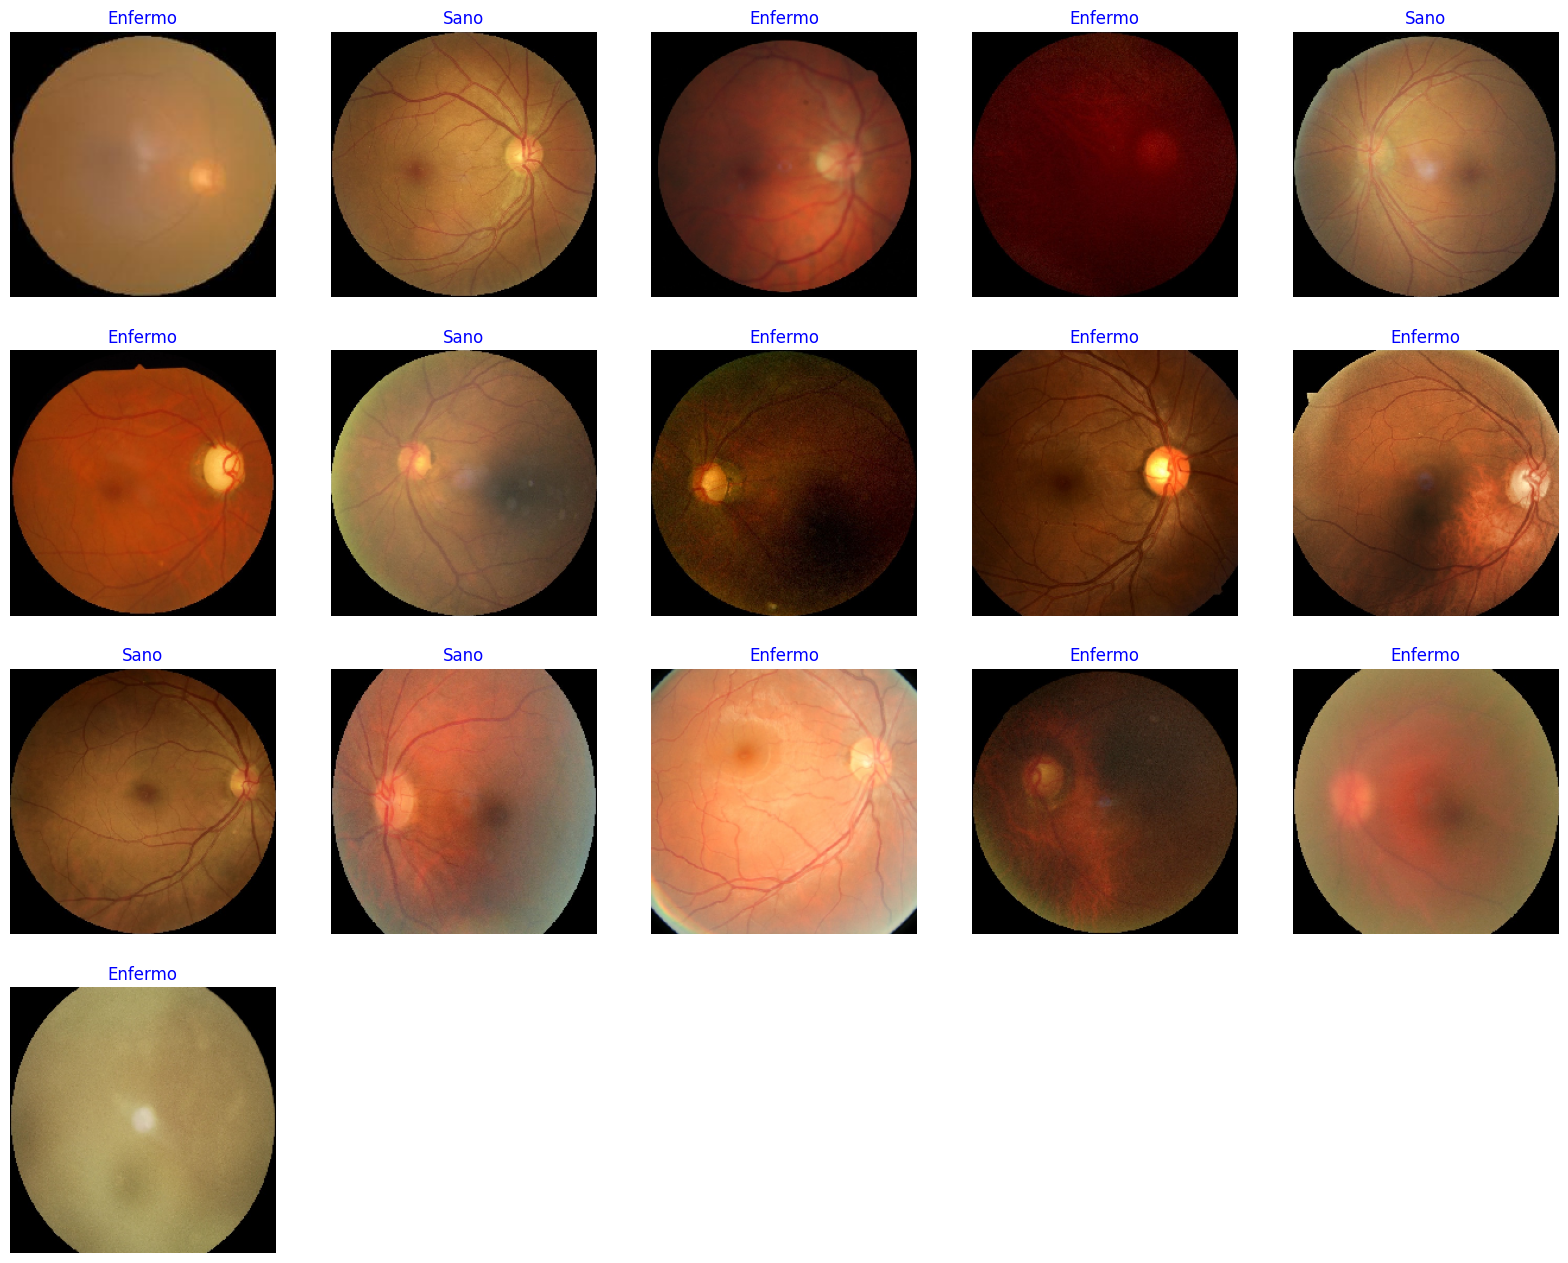

In [ ]:
show_images(train_gen)

# **Entrenar y Evaluar un Modelo de Aprendizaje Automático**



La función Solve entrena y evalúa un modelo de aprendizaje automático utilizando la arquitectura VGG19 preentrenada en ImageNet. Primero, configura nombres y rutas para guardar los resultados, pesos del modelo y registros de entrenamiento. Luego, inicializa un logger para registrar las métricas de entrenamiento y un callback para guardar los mejores pesos del modelo. Construye un nuevo modelo agregando capas adicionales a la VGG19, compila el modelo con el optimizador Adamax y la función de pérdida categorical_crossentropy, y si se especifica, carga el mejor modelo guardado previamente para continuar el entrenamiento desde donde se dejó.

Durante el entrenamiento, el modelo utiliza generadores de datos con callbacks para el ajuste de learning rate y el guardado de pesos. Después de entrenar, guarda el modelo en un archivo .h5 y lo evalúa en los datos de prueba y validación, registrando las métricas de precisión y pérdida en un archivo de texto. Finalmente, grafica la precisión del modelo durante las épocas de entrenamiento y validación, y muestra las métricas de evaluación junto con la fecha y hora actual para seguimiento.

E

In [ ]:
def Solve(nombre, learning, batch, rep, recuperar, epocas):
  full_name = nombre + "_learn_" + str(np.abs(np.log10(learning))) + "_batch_" + str(batch) + "_rep_" + str(rep)
  dest_folder = f"/content/drive/MyDrive/Reportes dataset2 v1/vgg19/{learning}/"
  temp_folder = f"/content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/{learning}/"
  file_name = dest_folder + full_name + ".txt"
  with open(file_name, 'a') as fid:
    fid.write("")
  # nombre del modelo h5
  file_model = dest_folder + full_name + ".h5"
  now = datetime.datetime.now()
  print(now.strftime("%d/%m/%Y %H:%M:%S"))
  print("Learning rate: " + str(learning) + "    batch size: " + str(batch) + "    rep: " + str(rep))
  print("\n")
  # logger
  nombre_logger = dest_folder + full_name + "_log.csv"
  csv_logger = CSVLogger(nombre_logger, append=True)

  # guardar los mejores pesos en cada epoch
  checkpoint_path = temp_folder + "temp_" + full_name + ".h5"
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                           verbose=1,
                                                           monitor='val_loss',
                                                           save_weights_only=True,
                                                           save_freq='epoch',
                                                           save_best_only=True)
  # Crear estructura del modelo
  img_size = (224, 224) # Tamaño de la imagen
  channels = 3 # Canales de la imagen (RGB)
  img_shape = (img_size[0], img_size[1], channels) # Forma de la imagen
  class_count = len(list(train_gen.class_indices.keys())) # Conteo de clases en la capa densa
  from tensorflow.keras.applications import VGG19

  base_model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max',
    classifier_activation='softmax')
  # Crear un nuevo modelo con el learning rate actual
  model = Sequential([
            base_model,
            BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
            Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
                  bias_regularizer=regularizers.l1(0.006), activation='relu'),
            Dropout(rate=0.45, seed=123),
            Dense(class_count, activation='softmax')
  ])

  # Compilar el modelo con el learning rate actual y el batch size definido
  model.compile(Adamax(learning_rate=learning), loss='categorical_crossentropy', metrics=['accuracy'])
  patience = 3 # número de epochs  para esperar para ajustar lr si el valor monitoreado no mejora
  stop_patience = 5 # número de epochs para esperar antes de detener el entrenamiento si el valor monitoreado no mejora
  threshold = 0.9 # si la precisión del entrenamiento es < threshold, ajustar la precisión del monitor; de lo contrario, monitorear la pérdida de validación
  factor = 0.5 # factor para reducir lr
    # se carga el mejor modelo que exista en archivo, si se pide modo recuperacion
  if recuperar == 1:
    try:
      model.load_weights(checkpoint_path)
    except:
      print("No existe el archivo temporal " + checkpoint_path)
      print("Se cancela la ejecución")
      return

  # modo entrenamiento, se debe eliminar cualquier temporal
  if recuperar == 0:
    if os.path.isfile(checkpoint_path):
      os.remove(checkpoint_path)
    else:
      print("No existe previamente el archivo temporal " + checkpoint_path)
  callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                    factor=factor, batches=batch, epochs=epocas), csv_logger, checkpoint_callback]
  history = model.fit(x=train_gen, epochs=epocas, verbose=0, callbacks=callbacks,
                            validation_data=valid_gen, validation_steps=None, shuffle=False)
  # guardar el modelo
  model.save(file_model)
  print("Modelo "+ full_name + " guardado con exito")
  print("\n")

  print("Testeando el modelo...")
  print("\n")
  test_lost, test_acc= model.evaluate(test_gen)
  print("\n")

  print("Validating...")
  print("\n")
  val_lost, val_acc= model.evaluate(valid_gen)
  print("\n")
  # escribir archivo de control
  now = datetime.datetime.now()
  dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
  with open(file_name, 'a') as fid:
    fid.write(dt_string + "\n")
    fid.write("Learning rate: " + str(learning) + "    batch size: " + str(batch) + "    rep: " + str(rep) + "\n")
    fid.write("Test Accuracy: " +  str(round(test_acc,3)) + "    Test Loss: " + str(round(test_lost,4)) + "    Val Accuracy: " + str(round(val_acc,3)) + "    Val Loss: " + str(round(val_lost,4)) + "\n")
    fid.write("\n")

  print("\n")
  print("Test Accuracy:\t", test_acc)
  print("Test Loss:    \t", test_lost)
  print("Val Accuracy: \t", val_acc)
  print("Val Loss:     \t", val_lost)
  print("\n")

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.xlabel('Epoch')
  plt.legend(["Test accuracy","Val accuracy"], loc ="lower right")
  plt.grid()
  plt.show()

  now = datetime.datetime.now()
  print(now.strftime("%d/%m/%Y %H:%M:%S"))
  print("\n")
  print("==================================================================")
  print("\n")
  print("\n")

27/08/2024 14:37:56
Learning rate: 0.0001    batch size: 16    rep: 6


80134624/80134624 [==============================] - 0s 0us/step
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     2.433   88.822   2.33797  90.843   0.00010  0.00010  accuracy     0.00   1307.89 

Epoch 1: val_loss improved from inf to 2.33797, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_6.h5
 2 /40     2.086   91.293   1.98684  92.289   0.00010  0.00010  val_loss    15.02    57.92  

Epoch 2: val_loss improved from 2.33797 to 1.98684, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_6.h5
 3 /40     1.901   92.257   1.83222  92.289   0.00010  0.00010  val_loss     7.78    57.75  

Epoch 3: val_loss improved from 1.98684 to 1.83222, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg

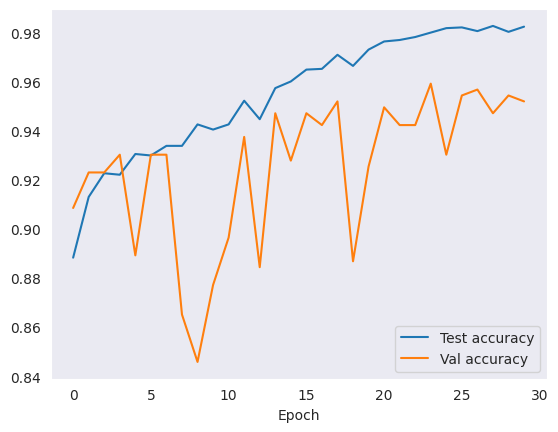

27/08/2024 15:36:46








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-4, batch = 16, rep = 6, recuperar = 1, epocas = 40)

30/08/2024 18:12:12
Learning rate: 0.0001    batch size: 16    rep: 7


80134624/80134624 [==============================] - 0s 0us/step
No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_7.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     6.153   70.594   6.04129  76.867   0.00010  0.00010  accuracy     0.00    475.47 

Epoch 1: val_loss improved from inf to 6.04129, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_7.h5
 2 /40     5.392   78.789   5.19537  74.699   0.00010  0.00010  accuracy    11.61    61.78  

Epoch 2: val_loss improved from 6.04129 to 5.19537, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_7.h5
 3 /40     4.862   80.657   5.13779  83.373   0.00010  0.0

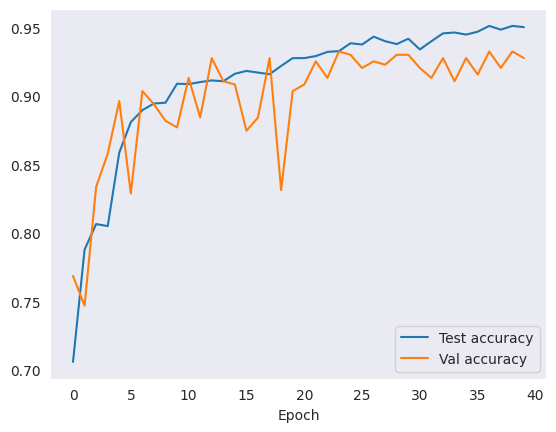

30/08/2024 19:07:32








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-4, batch = 16, rep = 7, recuperar = 0, epocas = 40)

30/08/2024 19:10:58
Learning rate: 0.0001    batch size: 16    rep: 8


No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_8.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     6.235   73.275   6.06328  76.627   0.00010  0.00010  accuracy     0.00    72.45  

Epoch 1: val_loss improved from inf to 6.06328, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_8.h5
 2 /40     5.465   83.670   5.41403  85.060   0.00010  0.00010  accuracy    14.19    61.27  

Epoch 2: val_loss improved from 6.06328 to 5.41403, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_8.h5
 3 /40     4.954   84.242   4.98609  73.976   0.00010  0.00010  accuracy     0.68    60.59  

Epoch 3: val_loss improved fr

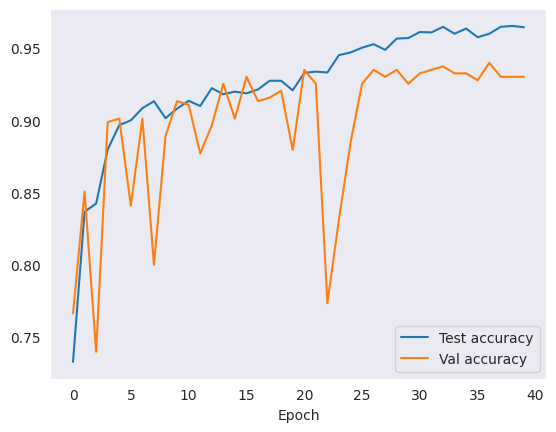

30/08/2024 19:59:16








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-4, batch = 16, rep = 8, recuperar = 0, epocas = 40)

30/08/2024 20:02:17
Learning rate: 0.0001    batch size: 16    rep: 9


No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_9.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


 1 /40     6.289   75.083   7.85122  73.976   0.00010  0.00010  accuracy     0.00    67.39  

Epoch 1: val_loss improved from inf to 7.85122, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_9.h5
 2 /40     5.591   84.513   5.35402  87.229   0.00010  0.00010  accuracy    12.56    60.26  

Epoch 2: val_loss improved from 7.85122 to 5.35402, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_9.h5
 3 /40     5.072   87.767   4.89091  89.639   0.00010  0.00010  accuracy     3.85    60.27  

Epoch 3: val_loss improved from 5.35402 to 4.89091, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_9.h5
 4 /40     4.621   90.871   4.49369  92.530   0.00010  0.00010  val_loss     8.12    61.50  

Epoch 4: val_loss improved from 4.89091 to 4.49369, saving model to /cont

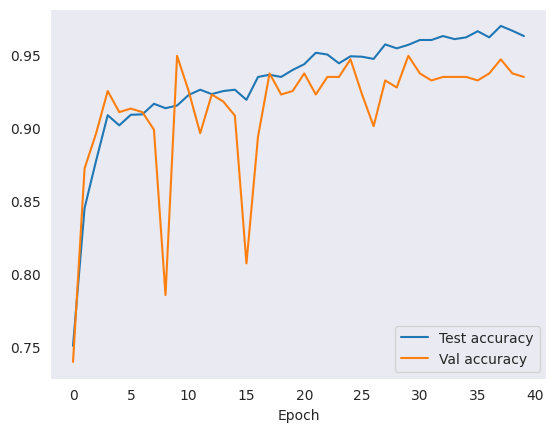

30/08/2024 20:48:08








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-4, batch = 16, rep = 9, recuperar = 0, epocas = 40)

30/08/2024 20:51:01
Learning rate: 0.0001    batch size: 16    rep: 10


No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_10.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


 1 /40     6.123   76.650   6.08249  73.976   0.00010  0.00010  accuracy     0.00    66.98  

Epoch 1: val_loss improved from inf to 6.08249, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_10.h5
 2 /40     5.371   84.664   5.26949  80.964   0.00010  0.00010  accuracy    10.46    60.92  

Epoch 2: val_loss improved from 6.08249 to 5.26949, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_10.h5
 3 /40     4.838   86.653   4.62156  90.120   0.00010  0.00010  accuracy     2.35    60.71  

Epoch 3: val_loss improved from 5.26949 to 4.62156, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.0001/temp_vgg19_retina_v1_40_learn_4.0_batch_16_rep_10.h5
 4 /40     4.329   88.852   4.23449  86.988   0.00010  0.00010  accuracy     2.54    60.83  

Epoch 4: val_loss improved from 4.62156 to 4.23449, saving model to /c

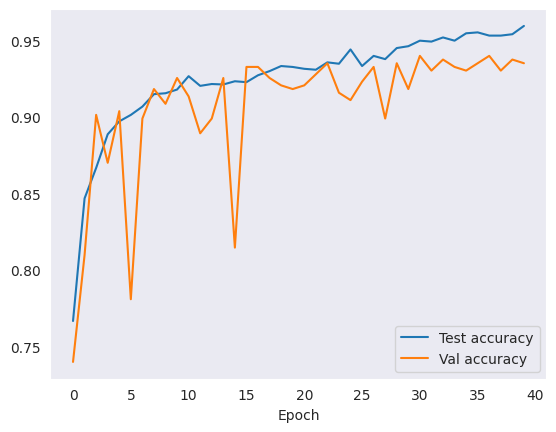

30/08/2024 21:40:57








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-4, batch = 16, rep = 10, recuperar = 0, epocas = 40)

02/09/2024 20:10:17
Learning rate: 0.001    batch size: 16    rep: 6


80134624/80134624 [==============================] - 3s 0us/step
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     4.100   70.684   3.67062  73.976   0.00100  0.00100  accuracy     0.00   1756.86 

Epoch 1: val_loss improved from inf to 3.67062, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_6.h5
 2 /40     2.270   74.691   2.19701  73.976   0.00100  0.00100  accuracy     5.67    57.28  

Epoch 2: val_loss improved from 3.67062 to 2.19701, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_6.h5
 3 /40     1.507   79.090   1.35574  74.940   0.00100  0.00100  accuracy     5.89    57.84  

Epoch 3: val_loss improved from 2.19701 to 1.35574, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/

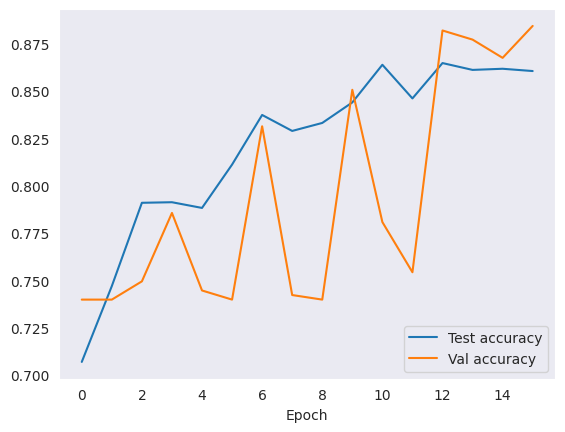

02/09/2024 20:59:55








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-3, batch = 16, rep = 6, recuperar = 0, epocas = 40)

02/09/2024 21:00:06
Learning rate: 0.001    batch size: 16    rep: 7


No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_7.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


 1 /40     3.696   72.221   2.57104  77.108   0.00100  0.00100  accuracy     0.00    63.28  

Epoch 1: val_loss improved from inf to 2.57104, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_7.h5
 2 /40     1.976   74.902   1.68190  74.217   0.00100  0.00100  accuracy     3.71    59.07  

Epoch 2: val_loss improved from 2.57104 to 1.68190, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_7.h5
 3 /40     1.391   74.691  574.95453 73.976   0.00100  0.00050  accuracy    -0.28    58.63  

Epoch 3: val_loss did not improve from 1.68190
 4 /40     1.124   75.234   1.12175  73.976   0.00050  0.00050  accuracy     0.44    58.43  

Epoch 4: val_loss improved from 1.68190 to 1.12175, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_7.h5
 5 /40     0.994   75.776   0

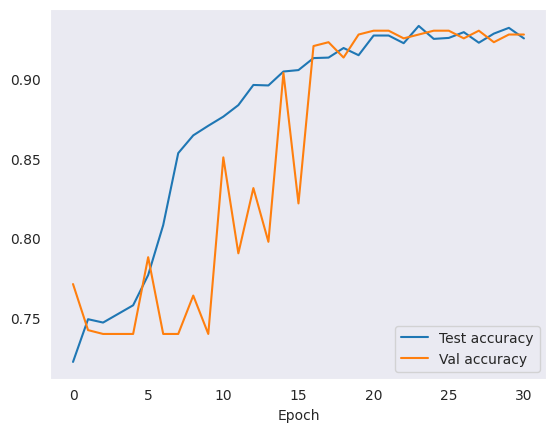

02/09/2024 21:36:23








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-3, batch = 16, rep = 7, recuperar = 0, epocas = 40)

04/09/2024 18:36:21
Learning rate: 0.001    batch size: 16    rep: 8


80134624/80134624 [==============================] - 3s 0us/step
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     3.890   72.914   2.87139  73.976   0.00100  0.00100  accuracy     0.00    727.83 

Epoch 1: val_loss improved from inf to 2.87139, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_8.h5
 2 /40     2.069   74.209   1.69777  75.181   0.00100  0.00100  accuracy     1.78    57.29  

Epoch 2: val_loss improved from 2.87139 to 1.69777, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_8.h5
 3 /40     1.403   74.209   1.32134  73.976   0.00100  0.00050  accuracy     0.00    57.77  

Epoch 3: val_loss improved from 1.69777 to 1.32134, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/

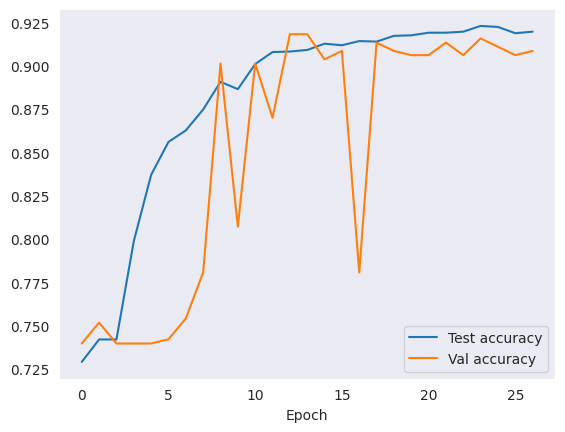

04/09/2024 19:19:27








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-3, batch = 16, rep = 8, recuperar = 0, epocas = 40)

06/09/2024 17:49:47
Learning rate: 0.001    batch size: 16    rep: 9


No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_9.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     3.432   73.305   2.30474  74.458   0.00100  0.00100  accuracy     0.00    632.55 

Epoch 1: val_loss improved from inf to 2.30474, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_9.h5
 2 /40     1.697   74.992   1.71443  74.940   0.00100  0.00100  accuracy     2.30    60.50  

Epoch 2: val_loss improved from 2.30474 to 1.71443, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_9.h5
 3 /40     1.163   75.776   1.47998  73.976   0.00100  0.00100  accuracy     1.04    60.28  

Epoch 3: val_loss improved from 1

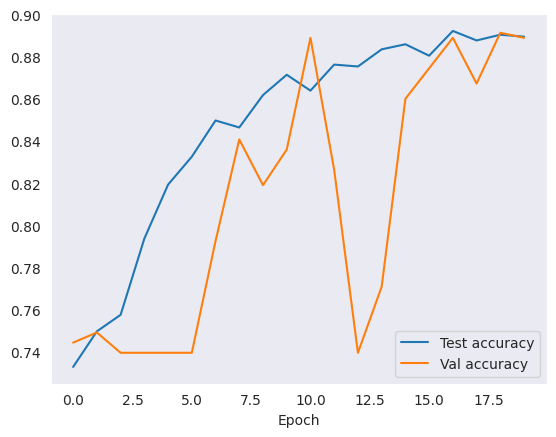

06/09/2024 18:26:40








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-3, batch = 16, rep = 9, recuperar = 0, epocas = 40)

06/09/2024 18:29:48
Learning rate: 0.001    batch size: 16    rep: 10


No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_10.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


 1 /40     3.679   72.341   2.54533  75.663   0.00100  0.00100  accuracy     0.00    65.70  

Epoch 1: val_loss improved from inf to 2.54533, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_10.h5
 2 /40     1.990   73.757   1.66772  73.976   0.00100  0.00100  accuracy     1.96    58.29  

Epoch 2: val_loss improved from 2.54533 to 1.66772, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_10.h5
 3 /40     1.399   74.541   1.30896  73.976   0.00100  0.00100  accuracy     1.06    56.97  

Epoch 3: val_loss improved from 1.66772 to 1.30896, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.001/temp_vgg19_retina_v1_40_learn_3.0_batch_16_rep_10.h5
 4 /40     1.071   75.836   1.94315  73.976   0.00100  0.00100  accuracy     1.74    58.07  

Epoch 4: val_loss did not improve from 1.30896
 5 /40     0.842   79.331 

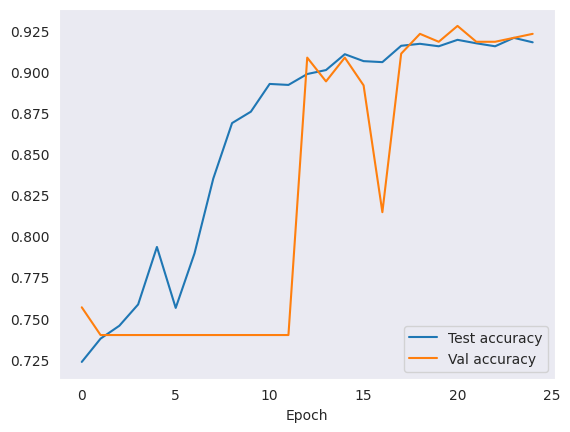

06/09/2024 18:59:18








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-3, batch = 16, rep = 10, recuperar = 0, epocas = 40)

07/09/2024 01:48:44
Learning rate: 0.01    batch size: 16    rep: 6


80134624/80134624 [==============================] - 1s 0us/step
No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_6.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     1.867   71.648   0.87293  73.976   0.01000  0.01000  accuracy     0.00    554.84 

Epoch 1: val_loss improved from inf to 0.87293, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_6.h5
 2 /40     0.664   73.637   0.64472  73.976   0.01000  0.01000  accuracy     2.78    56.64  

Epoch 2: val_loss improved from 0.87293 to 0.64472, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_6.h5
 3 /40     0.596   73.848  21942114.00000 73.976   0.01000  0.0100

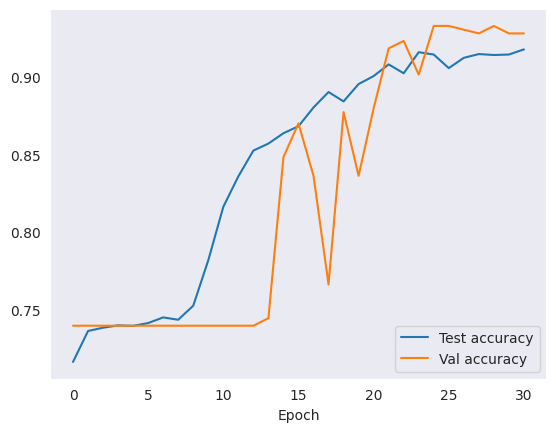

07/09/2024 02:32:48








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-2, batch = 16, rep = 6, recuperar = 0, epocas = 40)

07/09/2024 02:32:53
Learning rate: 0.01    batch size: 16    rep: 7


No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_7.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


 1 /40     1.654   71.076   0.74215  73.976   0.01000  0.01000  accuracy     0.00    61.44  

Epoch 1: val_loss improved from inf to 0.74215, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_7.h5
 2 /40     0.646   73.697   0.63252  73.976   0.01000  0.01000  accuracy     3.69    56.99  

Epoch 2: val_loss improved from 0.74215 to 0.63252, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_7.h5
 3 /40     0.597   73.637   0.60711  73.976   0.01000  0.00500  accuracy    -0.08    55.98  

Epoch 3: val_loss improved from 0.63252 to 0.60711, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_7.h5
 4 /40     0.549   73.938   0.56838  73.976   0.00500  0.00500  accuracy     0.33    57.25  

Epoch 4: val_loss improved from 0.60711 to 0.56838, saving model to /content/dr

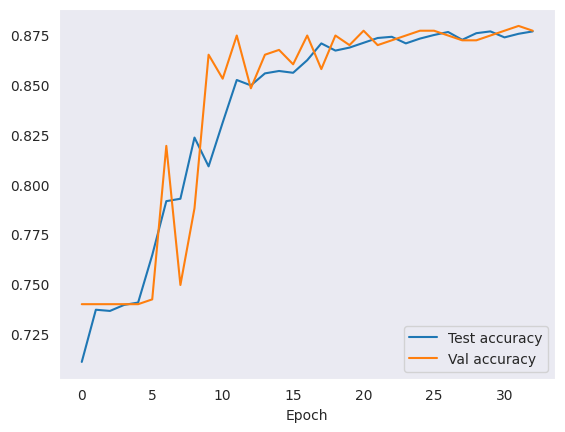

07/09/2024 03:08:45








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-2, batch = 16, rep = 7, recuperar = 0, epocas = 40)

07/09/2024 03:11:08
Learning rate: 0.01    batch size: 16    rep: 8


No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_8.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


 1 /40     1.839   70.714   0.77997  73.976   0.01000  0.01000  accuracy     0.00    61.92  

Epoch 1: val_loss improved from inf to 0.77997, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_8.h5
 2 /40     0.663   73.697   0.63413  73.976   0.01000  0.01000  accuracy     4.22    56.26  

Epoch 2: val_loss improved from 0.77997 to 0.63413, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_8.h5
 3 /40     0.592   73.848   0.60472  73.976   0.01000  0.01000  accuracy     0.20    57.24  

Epoch 3: val_loss improved from 0.63413 to 0.60472, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_8.h5
 4 /40     0.584   74.330   0.57875  73.976   0.01000  0.01000  accuracy     0.65    57.41  

Epoch 4: val_loss improved from 0.60472 to 0.57875, saving model to /content/dr

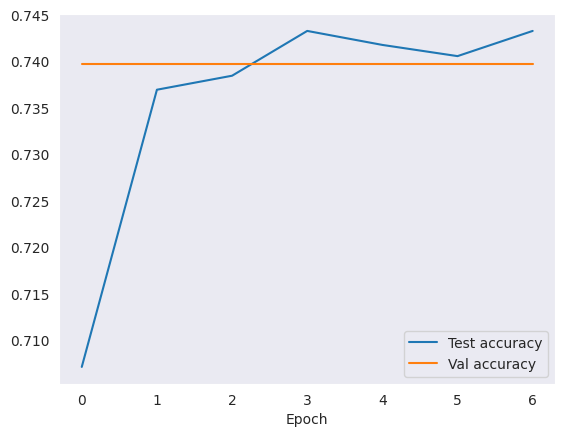

07/09/2024 03:18:57








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-2, batch = 16, rep = 8, recuperar = 0, epocas = 40)

07/09/2024 03:21:01
Learning rate: 0.01    batch size: 16    rep: 9


No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_9.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


 1 /40     1.937   71.076   0.82957  73.976   0.01000  0.01000  accuracy     0.00    60.69  

Epoch 1: val_loss improved from inf to 0.82957, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_9.h5
 2 /40     0.680   73.908  19541554.00000 73.976   0.01000  0.01000  accuracy     3.98    55.82  

Epoch 2: val_loss did not improve from 0.82957
 3 /40     0.597   74.149  2900475.00000 73.976   0.01000  0.01000  accuracy     0.33    56.43  

Epoch 3: val_loss did not improve from 0.82957
 4 /40     0.585   73.998   0.57666  73.976   0.01000  0.00500  accuracy    -0.20    55.61  

Epoch 4: val_loss improved from 0.82957 to 0.57666, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_9.h5
 5 /40     0.537   74.119   0.57268  73.976   0.00500  0.00250  accuracy    -0.04    56.56  

Epoch 5: val_loss improved from 0.57666 to 0.57268, saving model 

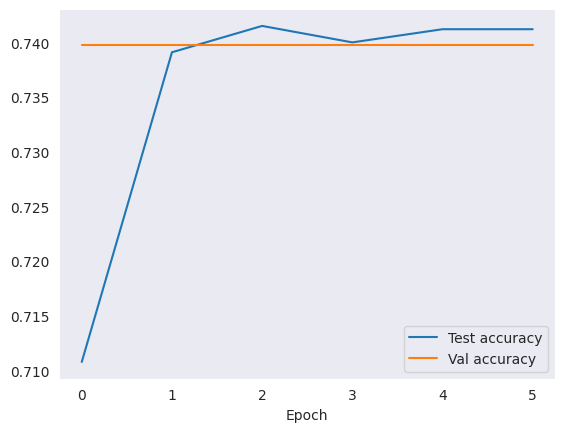

07/09/2024 03:27:48








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-2, batch = 16, rep = 9, recuperar = 0, epocas = 40)

07/09/2024 03:29:48
Learning rate: 0.01    batch size: 16    rep: 10


No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_10.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


 1 /40     1.738   71.347  343030656.00000 73.976   0.01000  0.01000  accuracy     0.00    63.65  

Epoch 1: val_loss improved from inf to 343030656.00000, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_10.h5
 2 /40     0.628   73.727   0.62736  73.976   0.01000  0.01000  accuracy     3.34    56.01  

Epoch 2: val_loss improved from 343030656.00000 to 0.62736, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_10.h5
 3 /40     0.530   75.053   0.62016  73.976   0.01000  0.01000  accuracy     1.80    56.86  

Epoch 3: val_loss improved from 0.62736 to 0.62016, saving model to /content/drive/MyDrive/modelcheckpoints dataset2 v1/vgg19/0.01/temp_vgg19_retina_v1_40_learn_2.0_batch_16_rep_10.h5
 4 /40     0.460   79.512   0.56926  73.976   0.01000  0.01000  accuracy     5.94    56.57  

Epoch 4: val_loss improved from 0.62016 to 0.56926, sa

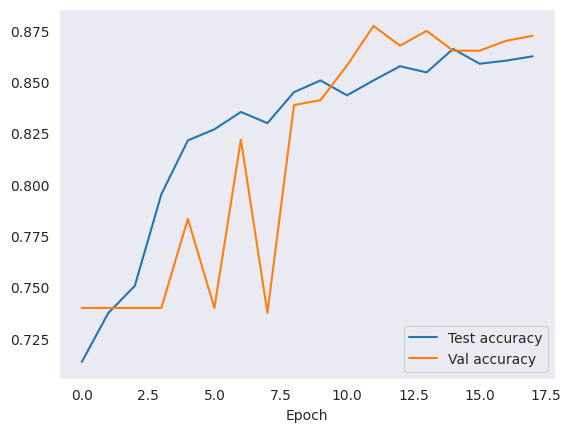

07/09/2024 03:50:11








In [ ]:
Solve(nombre = "vgg19_retina_v1_40", learning = 1e-2, batch = 16, rep = 10, recuperar = 0, epocas = 40)

In [ ]:
#cargar modelo
model=tf.keras.models.load_model("/content/drive/MyDrive/Reportes dataset2 v1/vgg19/0.0001/vgg19_retina_v1_40_learn_4.0_batch_16_rep_6.h5")

In [ ]:
#Obtener predicciones con el modelo ya entrenado
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0
 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1
 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0
 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1
 0 0 0 1 0 1 0 0]


Matriz de Confusión sin Normalizar
[[297  11]
 [ 10  97]]
              precision    recall  f1-score   support

     Enfermo       0.97      0.96      0.97       308
        Sano       0.90      0.91      0.90       107

    accuracy                           0.95       415
   macro avg       0.93      0.94      0.93       415
weighted avg       0.95      0.95      0.95       415



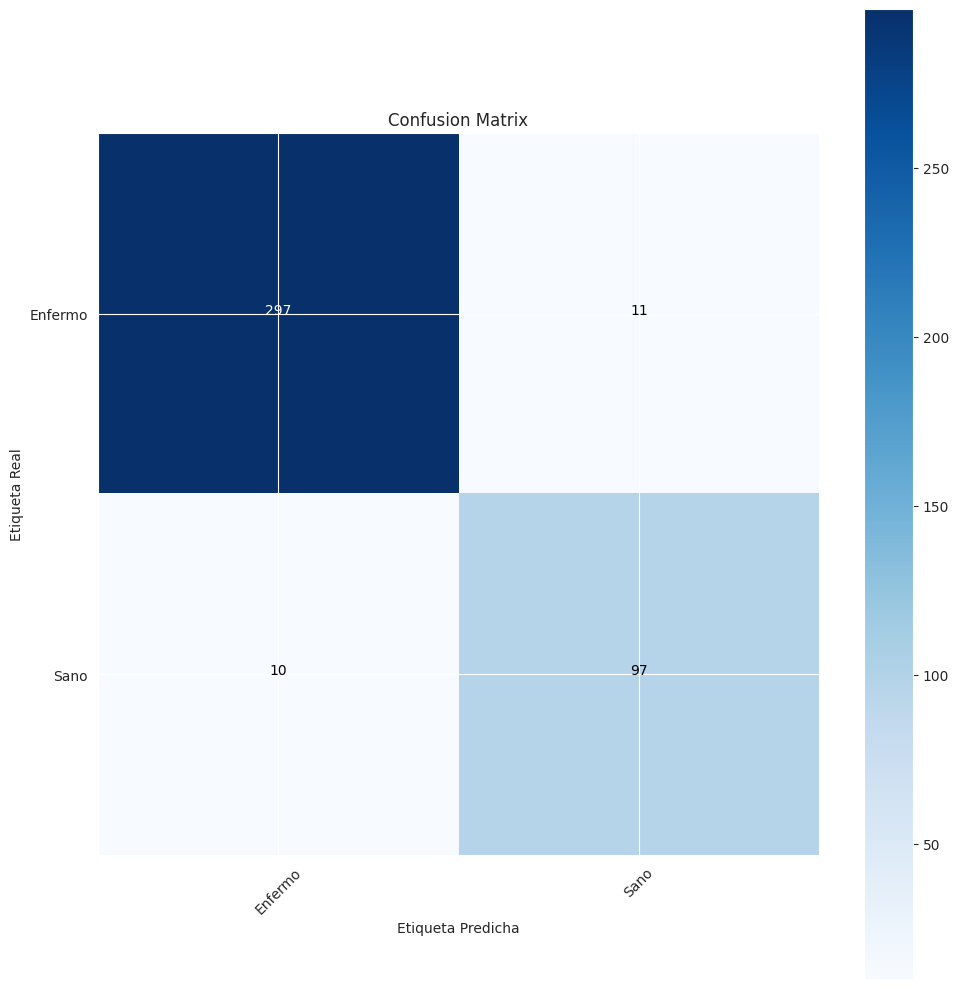

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Matriz de confusion
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Reporte de clasificacion de las diferentes clases
print(classification_report(test_gen.classes, y_pred, target_names= classes))

**1. Introducción**

**Objetivo**

El objetivo de este informe es documentar el proceso y los resultados obtenidos en la clasificación de imágenes de ojos sanos y ojos enfermos utilizando la arquitectura VGG19. Se busca evaluar la efectividad de tres diferentes learning rates (0.01, 0.001, 0.0001) en la precisión del modelo, con un batch size de 16 y repitiendo cada experimento diez veces a lo largo de 40 épocas.

**Arquitectura Utilizada**

VGG19, Es una extensión de (VGG16), con 19 capas de peso con una estructura similar pero más profunda que VGG16. Tiene 16 capas convolucionales y 3 capas totalmente conectadas, lo que ofrece una mayor capacidad de representación a costa de mayores requisitos computacionales.

**Dataset Utilizado**

El conjunto de datos utilizado en este estudio es "Clasificación de las enfermedades oculares" (Eyes Disease Classification), compilado por Guna Venkat Doddi y publicado en 2022. Este dataset incluye imágenes de retina normales, retinopatía diabética, cataratas y glaucoma, con aproximadamente 1,000 imágenes diagnósticas por cada clase. Las enfermedades oculares abarcan una variedad de afecciones que afectan la visión y la salud ocular. El objetivo principal de este conjunto de datos es entrenar modelos de aprendizaje profundo para identificar patrones específicos asociados con cada una de estas enfermedades oculares. En esta primera fase del estudio, se decidió clasificar las imágenes en dos categorías (sano y enfermo) en lugar de cuatro (glaucoma, catarata, retinopatía diabética y sano). Esta decisión se tomó para simplificar el problema inicial y evaluar la capacidad del modelo para distinguir entre ojos sanos y cualquier patología ocular, lo que sienta las bases para estudios posteriores más detallados que aborden la clasificación específica de cada enfermedad.

**2. Metodología**

**Preprocesamiento de las Imágenes**

Las imágenes de retinoscopía utilizadas en este estudio se caracterizan por estar en formato .jpg o .jpeg; las imágenes de retinas normales, cataratas y glaucoma están en formato .jpg, mientras que las de retinopatía diabética están en formato .jpeg. Aunque el tamaño de estas imágenes no es relevante debido a la flexibilidad de las redes neuronales convolucionales, se realizaron los siguientes pasos de preprocesamiento para asegurar la calidad de los datos:

*  Redimensionamiento: Las imágenes fueron redimensionadas a 224x224 píxeles para cumplir con los requisitos de entrada de la arquitectura Vgg19.
*  Normalización: Las imágenes fueron normalizadas para tener valores de píxeles entre 0 y 1, lo que ayuda a acelerar el entrenamiento y mejorar la convergencia del modelo.
*  Augmentación de Datos: Se aplicaron técnicas de augmentación de datos como rotaciones, traslaciones, y flips horizontales para aumentar la variabilidad del dataset y mejorar la robustez del modelo.

**Hiperparámetros**

Para el desarrollo del modelo, se utilizaron los siguientes hiperparámetros y configuraciones:

*   Learning Rates: Se probaron tres tasas de aprendizaje diferentes: 0.01, 0.001 y 0.0001.
*   Batch Size: El tamaño del lote se fijó en 16 para todas las pruebas.
*   Número de Épocas: Cada modelo se entrenó durante 40 épocas.
*   Repeticiones: Se fijaron 10 repeticiones para cada learning rate.
*   Función de Pérdida: Se utilizó la función de pérdida de entropía cruzada (Cross-Entropy Loss) para la clasificación.
*   Función de Activación: La función de activación en la capa de salida fue Softmax, adecuada para la clasificación multiclase.
*   Optimización: Se utilizó el optimizador Adam, conocido por su eficiencia y adaptación del learning rate durante el entrenamiento.
*   Validación Cruzada: Se implementó un enfoque de validación cruzada para evaluar el desempeño del modelo y reducir el riesgo de sobreajuste

**Metodología de Prototipado Rápido (MPR)**

Se adoptó la Metodología de Prototipado Rápido (MPR) debido a su enfoque iterativo y ágil, que permite adaptar el modelo a medida que surgen nuevas necesidades y se recopilan datos adicionales. Esta metodología fomenta el uso de herramientas visuales para garantizar un desarrollo eficiente y efectivo del artefacto.

Durante el proceso de desarrollo, se integraron diferentes arquitecturas de aprendizaje profundo como VGG19, ResNet50, Xception, EfficientNet e InceptionV3 para el entrenamiento, validación y pruebas. La variación paramétrica de la tasa de aprendizaje (0.01, 0.001, 0.0001) y las métricas de precisión (accuracy) y pérdida de validación (val_loss) se utilizaron para evaluar el rendimiento del modelo.

El proceso de MPR incluye diferentes tipos de ciclos iterativos:

*  Ciclo 1: Evaluar los cinco modelos (VGG19, ResNet50, Xception, EfficientNet, InceptionV3) con un dataset de dos clases (sano y enfermo).
*  Ciclo 2: Evaluar los tres mejores modelos del ciclo anterior con un dataset de cuatro clases (glaucoma, catarata, retinopatía diabética, sano).
*  Ciclo 3: Escoger el mejor modelo basado en los resultados obtenidos en los ciclos anteriores.

Este ejercicio se encuentra en el ciclo 1.


**3. Análisis de Resultados**

**Comparación entre Learning Rates**

***Tabla General: Mejor Repeticion por Learning Rate***

|learning_rate|repeticion|mejor_val_accuracy|mejor_val_loss|
|---|---|---|---|
|0.0001|6|0.957|0.9441|
|0.001|3|0.937|0.2675|
|0.01|6|0.928|0.2323|

***Tabla Learning Rate 0.01***

|repeticion|	max_val_accuracy|	epoch_max_val_accuracy|min_val_loss|	epoch_min_val_loss|
|---|---|---|---|---|
|1|0.9036144614219666|14|0.2797232866287231|14|
|2|0.9277108311653136|23|0.2473064213991165|23|
|3|0.8771084547042847|16|0.283299446105957|22|
|4|0.7614457607269287|2|0.4887422919273376|6|
|5|0.8891566395759583|39|0.2718965709209442|39|
|6|0.9325301051|24|0.2322505862|27|
|7|0.8795180917|31|0.3000091016|32|
|8|0.739759028|0|0.5399676561|5|
|9|0.739759028|0|0.547794342|5|
|10|0.8771084547|11|0.3138235807|17|

***Tabla Learning Rate 0.001***

|repeticion|	max_val_accuracy|	epoch_max_val_accuracy|	min_val_loss|	epoch_min_val_loss|
|---|---|---|---|---|
|1|0.9253011942|22|0.2802216709|16|
|2|0.94457829|21|0.2573668063|25|
|3|0.939759016|22|0.2675327063|28|
|4|0.9253011942|26|0.2642936409|25|
|5|0.939759016|25|0.2939275801|23|
|6|0.9156626463|17|0.288097024|17|
|7|0.9301204681|20|0.3022685647|27|
|8|0.9325301051|33|0.2685949802|33|
|9|0.8915662766|18|0.2960601747|25|
|10|0.9277108312|20|0.3531019688|21|

***Tabla Learning Rate 0.0001***

|repeticion|	max_val_accuracy|	epoch_max_val_accuracy|	min_val_loss|	epoch_min_val_loss|
|---|---|---|---|---|
|1|0.9493975639|28|1.268596292|34|
|2|0.9542168379|39|1.059623241|38|
|3|0.942168653|22|1.074517131|38|
|4|0.9493975639|33|1.04436481|39|
|5|0.9325301051|24|0.5527432561|29|
|6|0.9590361714|23|0.9440901875|26|
|7|0.9325301051|23|1.121222019|39|
|8|0.939759016|36|0.8028456569|36|
|9|0.9493975639|9|1.419457674|39|
|10|0.939759016|30|1.093976259|39|


**4. Ajustes y Paciencia del Modelo**

En este estudio, se utilizó una configuración de paciencia (patience). La paciencia se refiere al número de épocas durante las cuales el modelo puede no mejorar antes de que se ajuste la tasa de aprendizaje. Si la precisión de validación no mejora después de un número determinado de épocas, la tasa de aprendizaje se reduce por un factor predeterminado.

El ajuste de la tasa de aprendizaje y la implementación de paciencia ayudaron a prevenir el sobreajuste y a mantener la eficiencia del modelo. En algunos casos, el modelo no alcanzó las 40 épocas completas debido a esta configuración, lo que resultó en la finalización anticipada del entrenamiento cuando no se observó mejora significativa en la precisión de validación o la pérdida de validación. Esta técnica de ajuste dinámico es crucial para encontrar el balance óptimo entre la precisión del modelo y la eficiencia del entrenamiento.

**5. Conclusiones**

***Conclusiones según Tablas Específicas***

* **Learning Rate 0.01**: Este learning rate mostró una variabilidad considerable en los resultados, con una precisión máxima que varía entre 73.98% y 93.25%. Aunque algunos modelos lograron buenas precisiones, la alta variabilidad sugiere una menor estabilidad en la convergencia del modelo.

* **Learning Rate 0.001**: Este learning rate fue el más consistente y proporcionó los mejores resultados en términos de precisión y estabilidad. La precisión máxima se mantuvo alrededor del 91.57% al 94.46%, con desviaciones estándar bajas, lo que sugiere que este learning rate es el más adecuado para la arquitectura VGG19 en este contexto.

* **Learning Rate 0.0001**: Aunque este learning rate también proporcionó buenos resultados de precisión, las pérdidas de validación fueron significativamente mayores, indicando una menor eficiencia en la convergencia del modelo. Sin embargo, la precisión máxima fue competitiva, alrededor del 93.25% al 95.90%.

***Conclusiones según la Tabla General***

* **Learning Rate 0.0001**: La repetición 6 logró una precisión de validación del 95.90% y una pérdida de validación de 0.9441, lo que demuestra el potencial de este learning rate para obtener altos niveles de precisión con pérdidas moderadas.

* **Learning Rate 0.001**: La repetición 3 alcanzó la precisión de validación con un 94.46% y una pérdida de validación de 0.2675, confirmando la consistencia y efectividad de este learning rate para la arquitectura.

* **Learning Rate 0.01**: La repetición 2 logró una precisión de validación del 92.80% y una pérdida de validación de 0.2473, lo que indica que, aunque puede lograr buenos resultados, es menos consistente comparado con los otros learning rates.

***Conclusión General***

El learning rate de 0.0001 resultó ser el más óptimo para el modelo, logrando una precisión de validación máxima del 95.90% con una pérdida de validación de 0.9441 en la mejor repetición. Aunque las pérdidas fueron más altas en comparación con otros learning rates, este valor permitió que el modelo alcanzara el mayor nivel de precisión en todas las pruebas, destacándose por su capacidad de evitar el sobreajuste y encontrar una convergencia efectiva a lo largo de las épocas.

El learning rate de 0.0001 proporcionó un balance entre la precisión máxima y la estabilidad del modelo, siendo el más adecuado para la arquitectura VGG19 cuando se busca maximizar la exactitud, incluso si el tiempo de convergencia puede ser ligeramente mayor. Esto lo convierte en la elección óptima para este experimento, especialmente cuando la prioridad es obtener los mejores resultados de clasificación en lugar de la rapidez en el entrenamiento.

**6. Anexos**

Se incluye en está sección el anexo a la carpeta de VGG19, en dónde se encontrarán las tablas expuestas en este informe, así como información adicional: https://drive.google.com/drive/folders/1AX5UaRo2DYdXXJYEbnmpaBuz6dJvUUhD?usp=sharing
